# CIS4930 -- Final Project
## Developed by: Chloe Fandino (Team Leader), Ashley James, Madelyne Wirbel, Chloe Nolan, Christopher Enlow

## Data Preprocessing

### Imports

In [76]:
# imports here :)

# TODO: DELETE ---> any imports that don't end up getting used by the end of the project !!!!

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.mstats import winsorize

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import ExtraTreesRegressor

from imblearn.over_sampling import SMOTE, SMOTENC

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

### Loading the data

In [77]:
df = pd.read_csv('OnlineNewsPopularity.csv') # import the data from the csv file --> convert to df

### Exploration of the dataset

In [78]:
# pd.set_option('display.max_rows', 100) # for purposes of looking at data --> need to see all rows

# basic intitial looks at the dataset
print(df.shape)

print(df.info())

(39644, 61)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords       

In [79]:
# Strip whitespace from column names
df.columns = df.columns.str.strip()

In [80]:
print(df.columns.tolist()) # print out all of the available columns

['url', 'timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', '

In [81]:
df.isnull().sum() # null values? --> NONE :)

url                             0
timedelta                       0
n_tokens_title                  0
n_tokens_content                0
n_unique_tokens                 0
                               ..
title_subjectivity              0
title_sentiment_polarity        0
abs_title_subjectivity          0
abs_title_sentiment_polarity    0
shares                          0
Length: 61, dtype: int64

In [82]:
df.duplicated().sum() # duplicate values? --> NONE :)

np.int64(0)

In [83]:
# check if any infinities exist in the dataframe
numeric_df = df.select_dtypes(include=[np.number])

has_inf = np.isinf(numeric_df.to_numpy()).any()

print(has_inf) # will need to handle in cleaning
inf_cols = numeric_df.columns[np.isinf(numeric_df.to_numpy()).any(axis=0)].tolist()
print("Columns with inf:", inf_cols)

False
Columns with inf: []


### Cleaning the data

In [84]:
# exploration of potentially non-predictive features
df['url'].nunique() == len(df) # each example has a different url --> not needed in the dataset
df = df.drop(columns = ['url'])

df = df.drop(columns = ['timedelta']) # number of days since posted until added to the dataset --> no predictive qualities

In [85]:
# Identify binary columns and ensure they are ints
binary_cols = [col for col in df.columns 
               if col.startswith("data_channel_is_") or col.startswith("weekday_is_")]

# ensure binary indicator columns are integers
df.columns = df.columns.str.strip()
print("Binary indicator columns:", binary_cols)

for col in binary_cols:
    df[col] = df[col].astype(int)

df[binary_cols].dtypes.head()

Binary indicator columns: ['data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday']


data_channel_is_lifestyle        int64
data_channel_is_entertainment    int64
data_channel_is_bus              int64
data_channel_is_socmed           int64
data_channel_is_tech             int64
dtype: object

In [86]:
# handling inf
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
print("Dataset shape after removing inf/NaN:", df.shape)

Dataset shape after removing inf/NaN: (39644, 59)


### Remove highly correlated features

Text(0.5, 1.0, 'Correlation Heatmap')

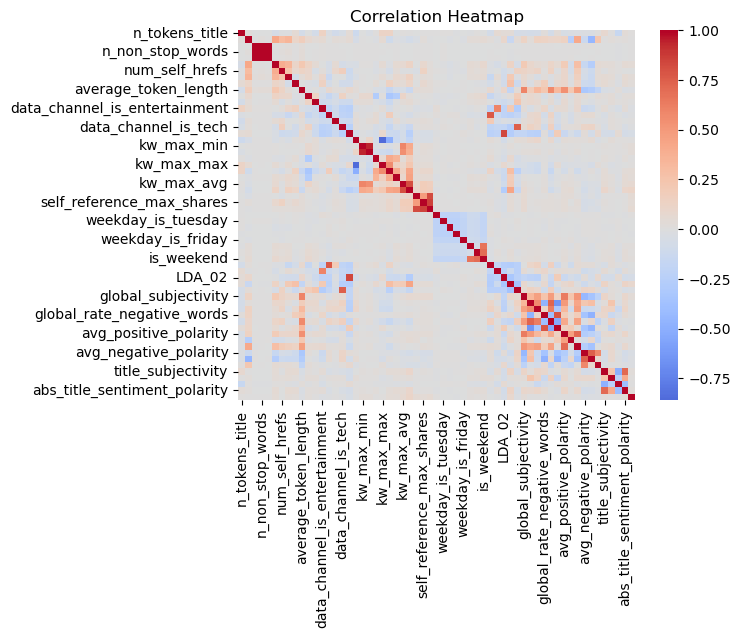

In [87]:
# test of feature correlation --> highly correlated features do not need to both be in dataset
df_correlation = df.corr()

sns.heatmap(df_correlation, cmap = 'coolwarm', center = 0)
plt.title("Correlation Heatmap")

In [88]:
X_corr = df.drop(columns=['shares'])
y_corr = df['shares']

def drop_correlated_by_importance(X, y, threshold=0.7, n_estimators=50, protected_cols=[]):
    model = ExtraTreesRegressor(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    model.fit(X, y)
    importances = pd.Series(model.feature_importances_, index=X.columns)

    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    corr_pairs = upper.stack().reset_index()
    corr_pairs.columns = ['feat1', 'feat2', 'corr']
    corr_pairs = corr_pairs[corr_pairs['corr'] > threshold]

    to_drop = set()
    for _, row in corr_pairs.iterrows():
        if row['feat1'] in protected_cols or row['feat2'] in protected_cols: # we dont want to drop binary indicator cols
            continue
        if importances[row['feat1']] >= importances[row['feat2']]:
            to_drop.add(row['feat2'])
        else:
            to_drop.add(row['feat1'])
    return list(to_drop)

In [89]:
columns_to_drop = drop_correlated_by_importance(
    X_corr, y_corr, threshold=0.80, n_estimators=50, protected_cols=binary_cols
)

print("Columns to drop due to high correlation:", columns_to_drop)
df = df.drop(columns=columns_to_drop)
# print new shape of dataset
print("Dataset shape after dropping correlated features:", df.shape)

Columns to drop due to high correlation: ['kw_max_avg', 'kw_min_min', 'self_reference_min_shares', 'kw_avg_min', 'self_reference_avg_sharess', 'n_non_stop_words', 'n_unique_tokens']
Dataset shape after dropping correlated features: (39644, 52)


In [90]:
# function with anomaly detection process --> first visualize, then calculate IQR

## Currently not used in the final cleaning process, but kept for potential future use ##

def anomaly_detection(feature):
    # first boxplot to see potential outliers
    sns.boxplot(x = df[feature], color = 'purple')
    plt.title(feature)
    plt.show()

    # second calculate outliers based on IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)

    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    anomalies = df[(df[feature] < lower) | (df[feature] > upper)]
    print('Anomalies: \n', anomalies) # prints a list of potential anomalies
    return

Skewed columns: ['n_tokens_content', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'kw_max_min', 'kw_min_max', 'kw_avg_avg', 'self_reference_max_shares', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_rate_negative_words', 'min_positive_polarity', 'abs_title_sentiment_polarity']


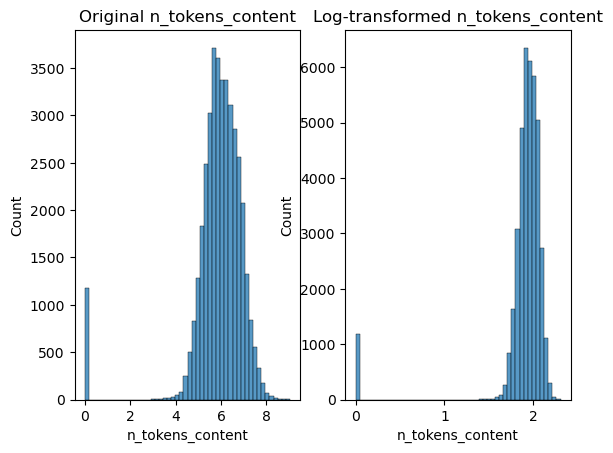

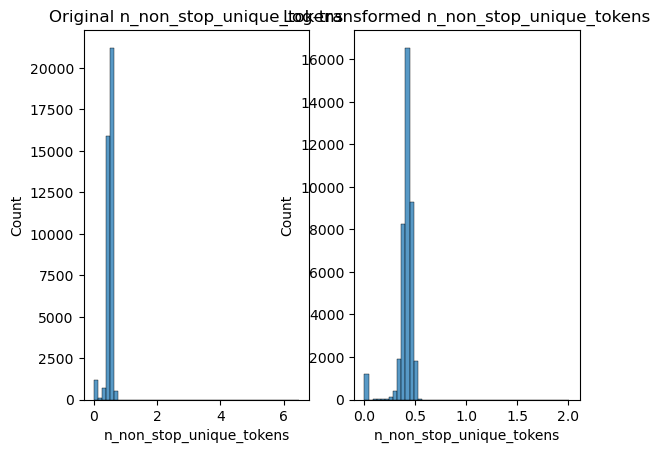

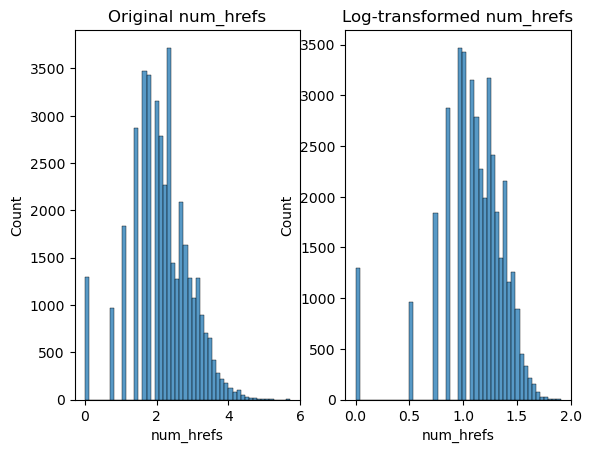

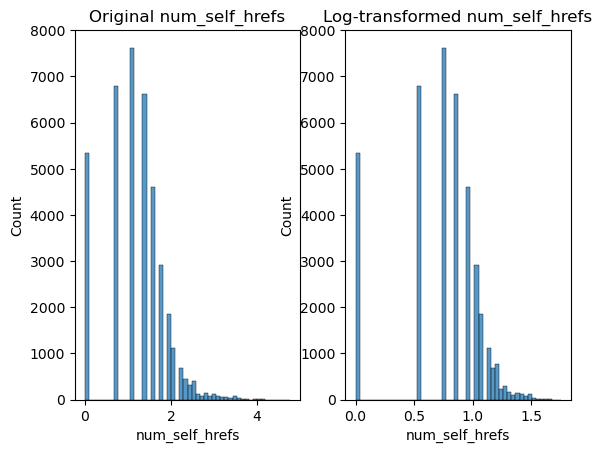

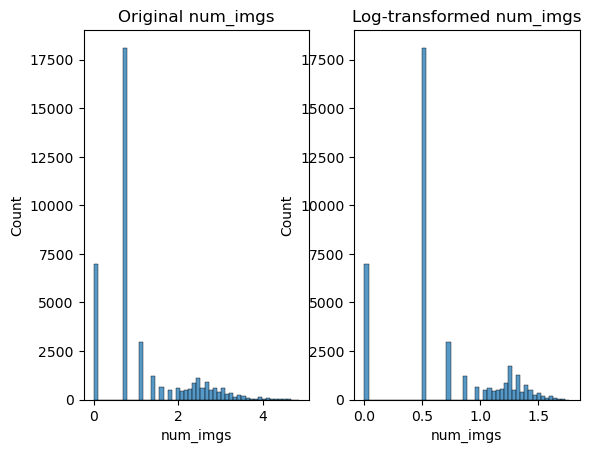

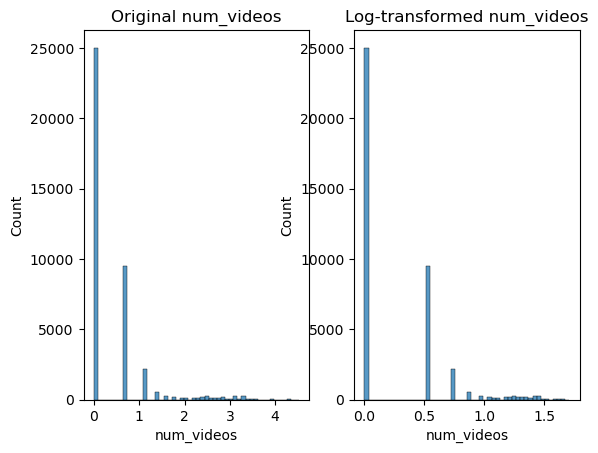

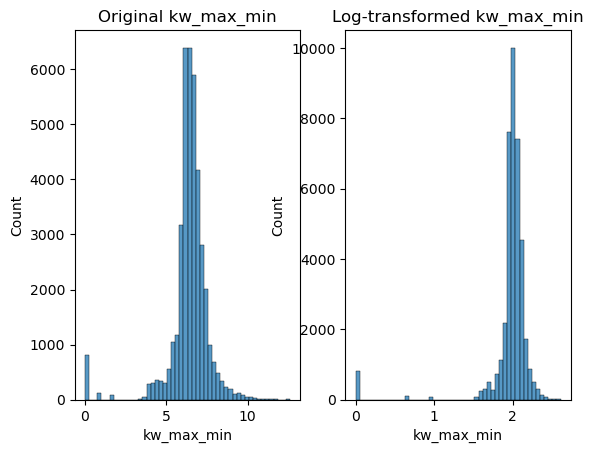

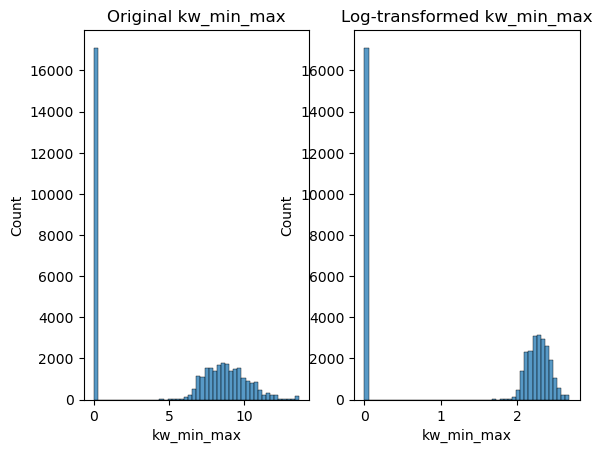

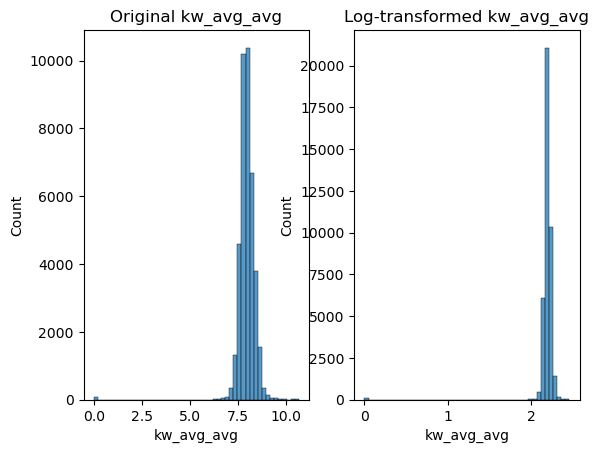

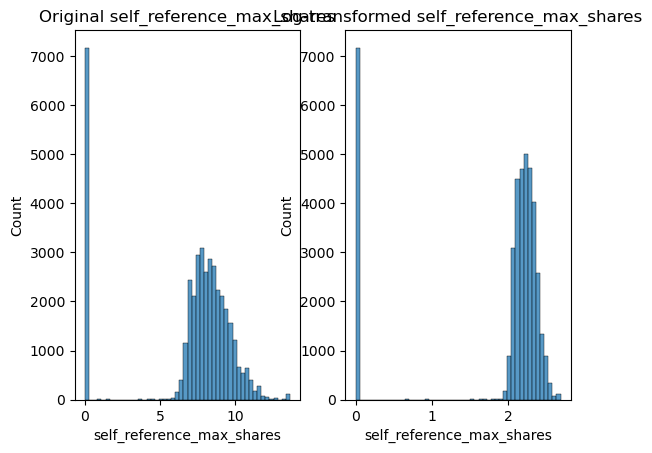

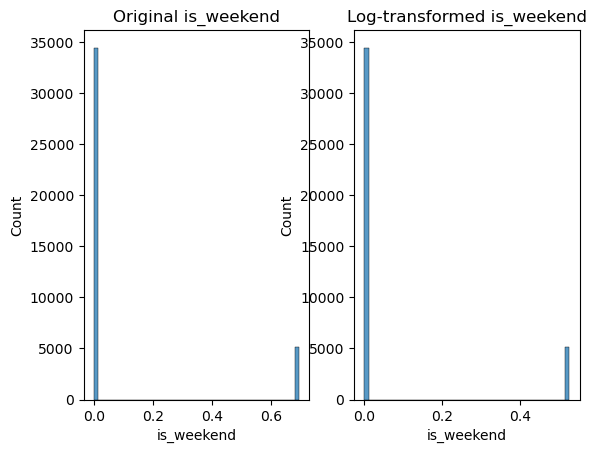

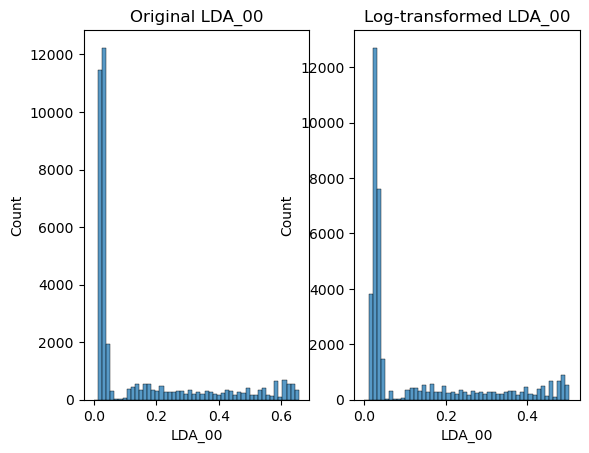

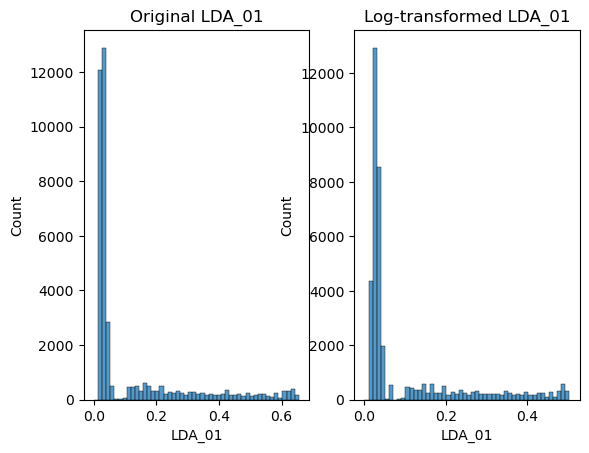

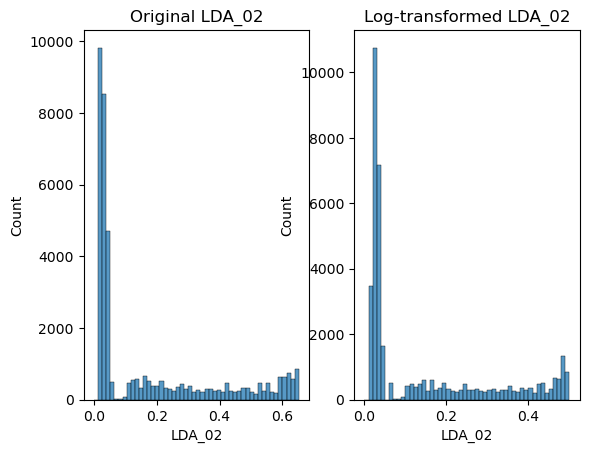

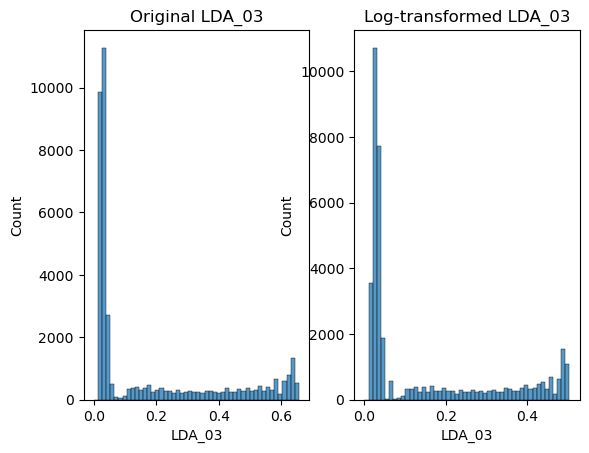

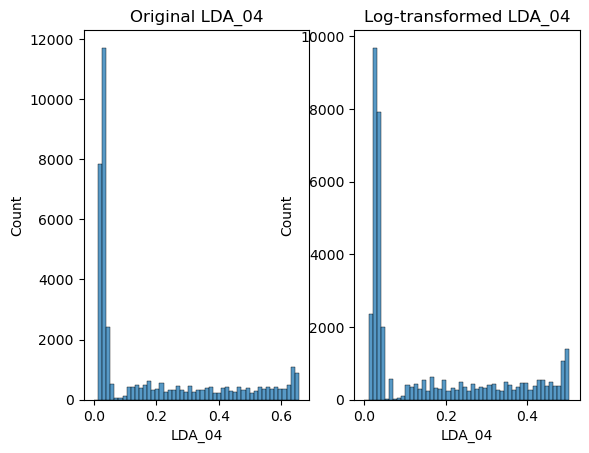

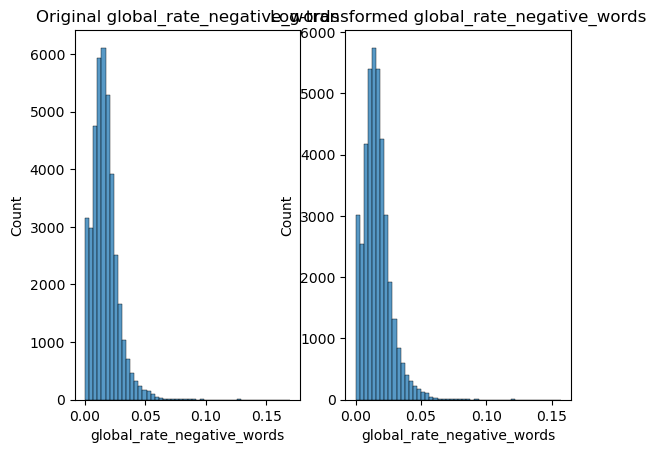

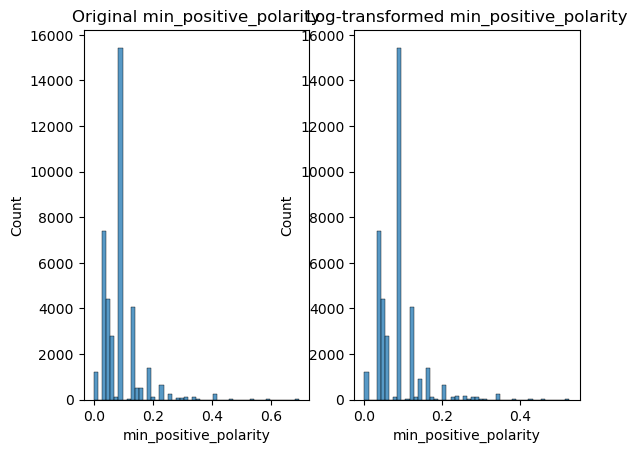

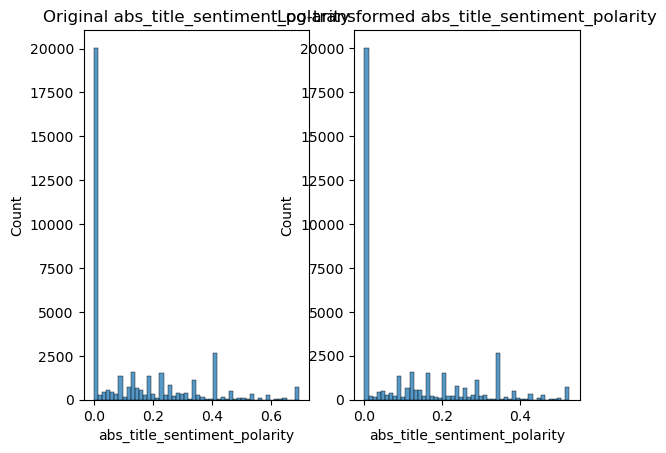

In [91]:
numeric_cols = [c for c in df.columns if c not in binary_cols + ['shares', 'shares_cat']]

skew_vals = df[numeric_cols].skew()

skew_threshold = 1.0
skewed_cols = skew_vals[skew_vals > skew_threshold].index.tolist()
print("Skewed columns:", skewed_cols)

# updated log transform to ensure safe handling
for col in skewed_cols:
    col_min = df[col].min()
    
    if col_min <= -1:
        df[col] = np.log1p(df[col] - col_min + 1.001)
    else:
        df[col] = np.log1p(df[col])

# visualization of transformation
for col in skewed_cols:
    fig, ax = plt.subplots(1, 2)
    sns.histplot(df[col], bins = 50, ax = ax[0])
    ax[0].set_title(f"Original {col}")
    
    sns.histplot(np.log1p(df[col]), bins = 50, ax = ax[1])
    ax[1].set_title(f"Log-transformed {col}")
    
    plt.show()


### Windsorization

In [92]:
# Identify numeric non-binary indicator columns
numeric_cols = [c for c in df.columns if c not in binary_cols + ['shares']]

# Winsorize
for col in numeric_cols:
    print(f"Before winsorizing {col}: min={df[col].min()}, max={df[col].max()}")
    df[col] = winsorize(df[col], limits=[0.01, 0.01])
    print(f"After winsorizing  {col}: min={df[col].min()}, max={df[col].max()}, skew={df[col].skew():.4f}\n")


Before winsorizing n_tokens_title: min=2.0, max=23.0
After winsorizing  n_tokens_title: min=6.0, max=15.0, skew=0.0983

Before winsorizing n_tokens_content: min=0.0, max=9.044875932248651
After winsorizing  n_tokens_content: min=0.0, max=7.722234744709607, skew=-2.9620

Before winsorizing n_non_stop_unique_tokens: min=0.0, max=6.478509642208569
After winsorizing  n_non_stop_unique_tokens: min=0.0, max=0.6528732751135122, skew=-3.1848

Before winsorizing num_hrefs: min=0.0, max=5.720311776607412
After winsorizing  num_hrefs: min=0.0, max=4.04305126783455, skew=-0.2751

Before winsorizing num_self_hrefs: min=0.0, max=4.762173934797756
After winsorizing  num_self_hrefs: min=0.0, max=3.044522437723423, skew=-0.0444

Before winsorizing num_imgs: min=0.0, max=4.859812404361672
After winsorizing  num_imgs: min=0.0, max=3.6375861597263857, skew=0.9543

Before winsorizing num_videos: min=0.0, max=4.5217885770490405
After winsorizing  num_videos: min=0.0, max=3.091042453358316, skew=2.2107

Befo

### Categorizing shares

Shares value counts:
 shares
1100     2308
1200     2018
1300     1740
1400     1592
1500     1323
         ... 
96100       1
443         1
58100       1
360         1
45000       1
Name: count, Length: 1454, dtype: int64


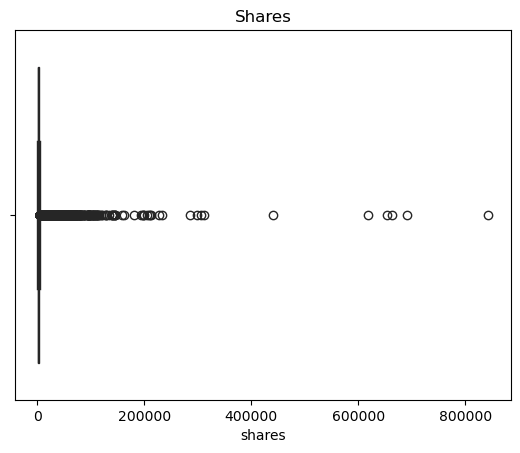

Q1: 946.0, Q2: 1400.0, Q3: 2800.0


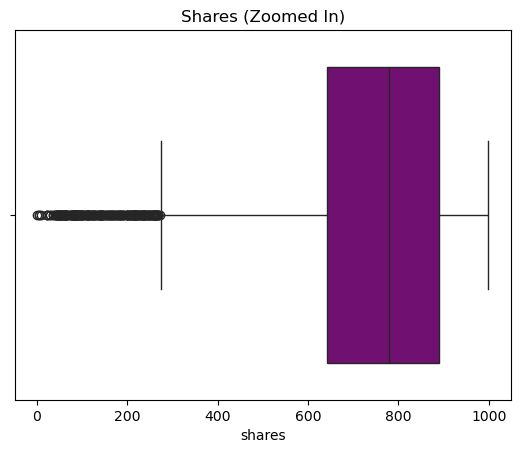

In [93]:
# transformation of problem into a classification --> outliers caused issues for articles with low shares in regression models

# explore shape of shares
print("Shares value counts:\n", df['shares'].value_counts())

# see box plot
sns.boxplot(x = df['shares'], color = 'purple')
plt.title('Shares')
plt.show()

# zoom in on lower range of shares
sns.boxplot(x = df[df['shares'] < 1000]['shares'], color = 'purple')
plt.title('Shares (Zoomed In)')

# print quartile ranges
q1, q2, q3 = np.percentile(df['shares'], [25, 50, 75])
print(f"Q1: {q1}, Q2: {q2}, Q3: {q3}")

In [94]:
# get quartiles
q1, q2, q3 = np.percentile(df['shares'], [25, 50, 75])

# assign 3 categories
def categorize(x):
    if x <= q1:
        return "Low"
    elif x <= q3:
        return "Average"
    else:
        return "High"

df['shares_cat'] = df['shares'].apply(categorize)

# encode
le = LabelEncoder()
df['y'] = le.fit_transform(df['shares_cat']) # set target equal to the categorized shares

# features
X = df.drop(columns=['shares','shares_cat','y'])
y = df['y']

# print number of instances in each category
print("Category distribution:\n", df['shares_cat'].value_counts())

Category distribution:
 shares_cat
Average    20084
Low         9930
High        9630
Name: count, dtype: int64


## Training and Testing

### Create Training Split

In [95]:
sm = SMOTENC(categorical_features=[X.columns.get_loc(c) for c in binary_cols],
             random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)
X_resampled, y_resampled = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [96]:
# Scale only continuous features
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])

### 1. Logistic Regression Model

In [97]:
# implement a logistic regression model --> basic model for classification
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_predict_log = log_model.predict(X_test)

Classification Report:

              precision    recall  f1-score   support

         Low       0.53      0.65      0.58      4017
     Average       0.65      0.55      0.60      4017
        High       0.60      0.55      0.57      4017

    accuracy                           0.58     12051
   macro avg       0.59      0.58      0.58     12051
weighted avg       0.59      0.58      0.58     12051



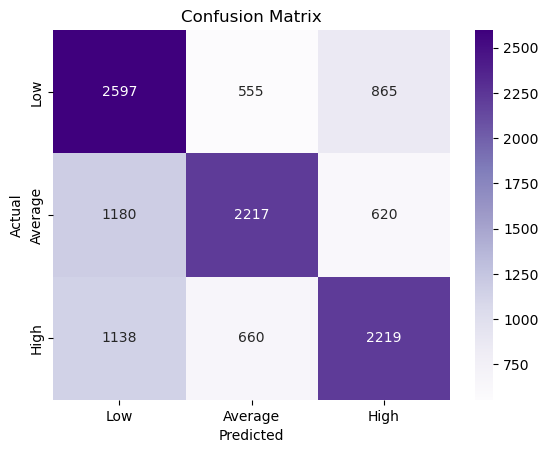

In [98]:
# evaluate linear regression performance
labels = ["Low", "Average", "High"]

print("Classification Report:\n")
print(classification_report(y_test, y_predict_log, target_names=labels))

cm = confusion_matrix(y_test, y_predict_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### 2. Neural Network

In [99]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
y_test_tensor  = torch.tensor(y_test.to_numpy(), dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [100]:
class ClassificationNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 51),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(51, 26),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(26, num_classes)  # output layer
        )

    def forward(self, x):
        return self.model(x)


In [101]:
model = ClassificationNN(input_dim=X_train_tensor.shape[1], num_classes=3)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

Epoch 10/100 | Train Loss: 0.8126 | Test Loss: 0.8010
Epoch 20/100 | Train Loss: 0.8028 | Test Loss: 0.7951
Epoch 30/100 | Train Loss: 0.7982 | Test Loss: 0.7920
Epoch 40/100 | Train Loss: 0.7938 | Test Loss: 0.7915
Epoch 50/100 | Train Loss: 0.7922 | Test Loss: 0.7904
Epoch 60/100 | Train Loss: 0.7898 | Test Loss: 0.7888
Epoch 70/100 | Train Loss: 0.7857 | Test Loss: 0.7884
Epoch 80/100 | Train Loss: 0.7847 | Test Loss: 0.7887
Epoch 90/100 | Train Loss: 0.7835 | Test Loss: 0.7888
Epoch 100/100 | Train Loss: 0.7838 | Test Loss: 0.7887
Classification Report:

              precision    recall  f1-score   support

         Low       0.53      0.78      0.63      4017
     Average       0.72      0.52      0.60      4017
        High       0.66      0.53      0.58      4017

    accuracy                           0.61     12051
   macro avg       0.63      0.61      0.61     12051
weighted avg       0.63      0.61      0.61     12051



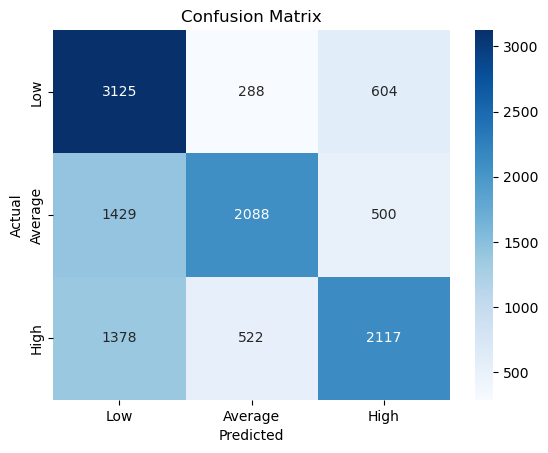

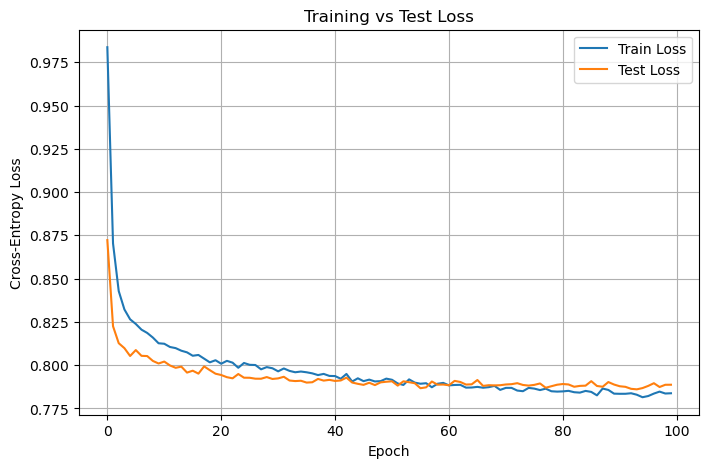

In [102]:
train_losses = []
test_losses = []

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * X_batch.size(0)

    train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Test loss
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_test_loss += loss.item() * X_batch.size(0)

    test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    y_pred = torch.argmax(outputs, dim=1)

labels = ["Low", "Average", "High"]

print("Classification Report:\n")
print(classification_report(y_test_tensor.numpy(), y_pred.numpy(), target_names=labels))

cm = confusion_matrix(y_test_tensor.numpy(), y_pred.numpy())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()